In this dataset our goal is to find the most under-developed countries. We can use that as an opportunity to dive into the technique known as clustering. For this purpose, we'll use the most popular algorithm called K-Means Clustering. 

We'll first see how it works on the example of scikit learn's implementation and then we'll try to implement it ourselves.

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv
/kaggle/input/unsupervised-learning-on-country-data/data-dictionary.csv


In [25]:
from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
data = pd.read_csv('../input/unsupervised-learning-on-country-data/Country-data.csv')
data

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


# Data analysis

Let's see how many null values are there?

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


We can see that there are no null values in this set.

Let's now inspect the statistical properties of the data

In [28]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


We can see that the data definitely needs scaling. Also, it seems that there are a couple of potential outliers in the dataset

One thing we don't for clustering is the country names' column, therefore we will drop it

In [29]:
country_names = data['country']
data = data.drop(['country'], axis='columns')

Let's inspect the correlation of columns

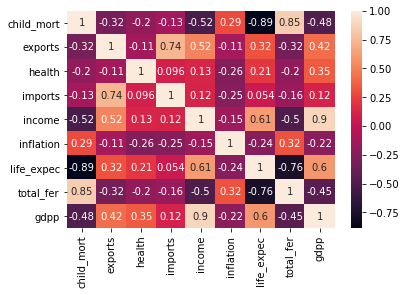

In [30]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)

We can see a few columns have strong correlations:
 - child_mort - total_fer 
 - child_mort - life_expec
 - exports - imports
 - income - gdpp
 - life_expec - total_fer

In [31]:
# sns.pairplot(data)

# Data preprocessing

In [32]:
scikit_copy = data.copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(scikit_copy)

# Clustering

We're going to use the K-Means Clustering algorithm. Since we don't have to choose a specific number of clusters. we will choose their number using the elbow method.

In kmeans, we can define a cost function as the sum of distances between each point and the center of the cluster it's assigned to. This cost if often called *inertia*. We want this cost to be as low as possible, but at the same time we don't want to many clusters, because that wouldn't be very informative.

The elbow method means that we will plot the inertia as a funciton of number of clusters. For the first couple values, the cost should drastically decrease with each new cluster. But, at some point curve will begin to "flatten". This point is exactly the value we're looking for. 

The plot we'll look a bit like bent arm and the point in question can remind the place where an elbow should be. Hence the name of this method.

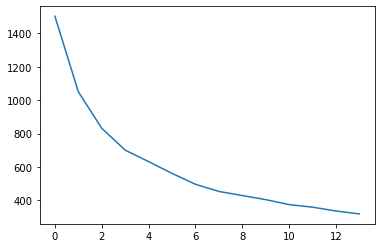

In [33]:
cost_values = []
for k in range(1, 15):
    model = KMeans(n_clusters=k)
    model.fit(scaled_data)
    cost_values.append(model.inertia_)

plt.plot(cost_values)

We can see that the curve begins somewhere around 3. So that will be our k.

In [34]:
k = 3
model = KMeans(n_clusters=k)
clusters = model.fit_predict(scaled_data)

In [58]:
scikit_copy['country'] = country_names
scikit_copy['cluster'] = clusters
scikit_copy

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster,country
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2,Afghanistan
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0,Albania
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0,Algeria
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2,Angola
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0,Antigua and Barbuda
...,...,...,...,...,...,...,...,...,...,...,...
162,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,0,Vanuatu
163,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,0,Venezuela
164,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,0,Vietnam
165,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,2,Yemen


In [59]:
scikit_copy['cluster'].value_counts()

0    84
2    47
1    36
Name: cluster, dtype: int64

Let's try to visualize the clusters

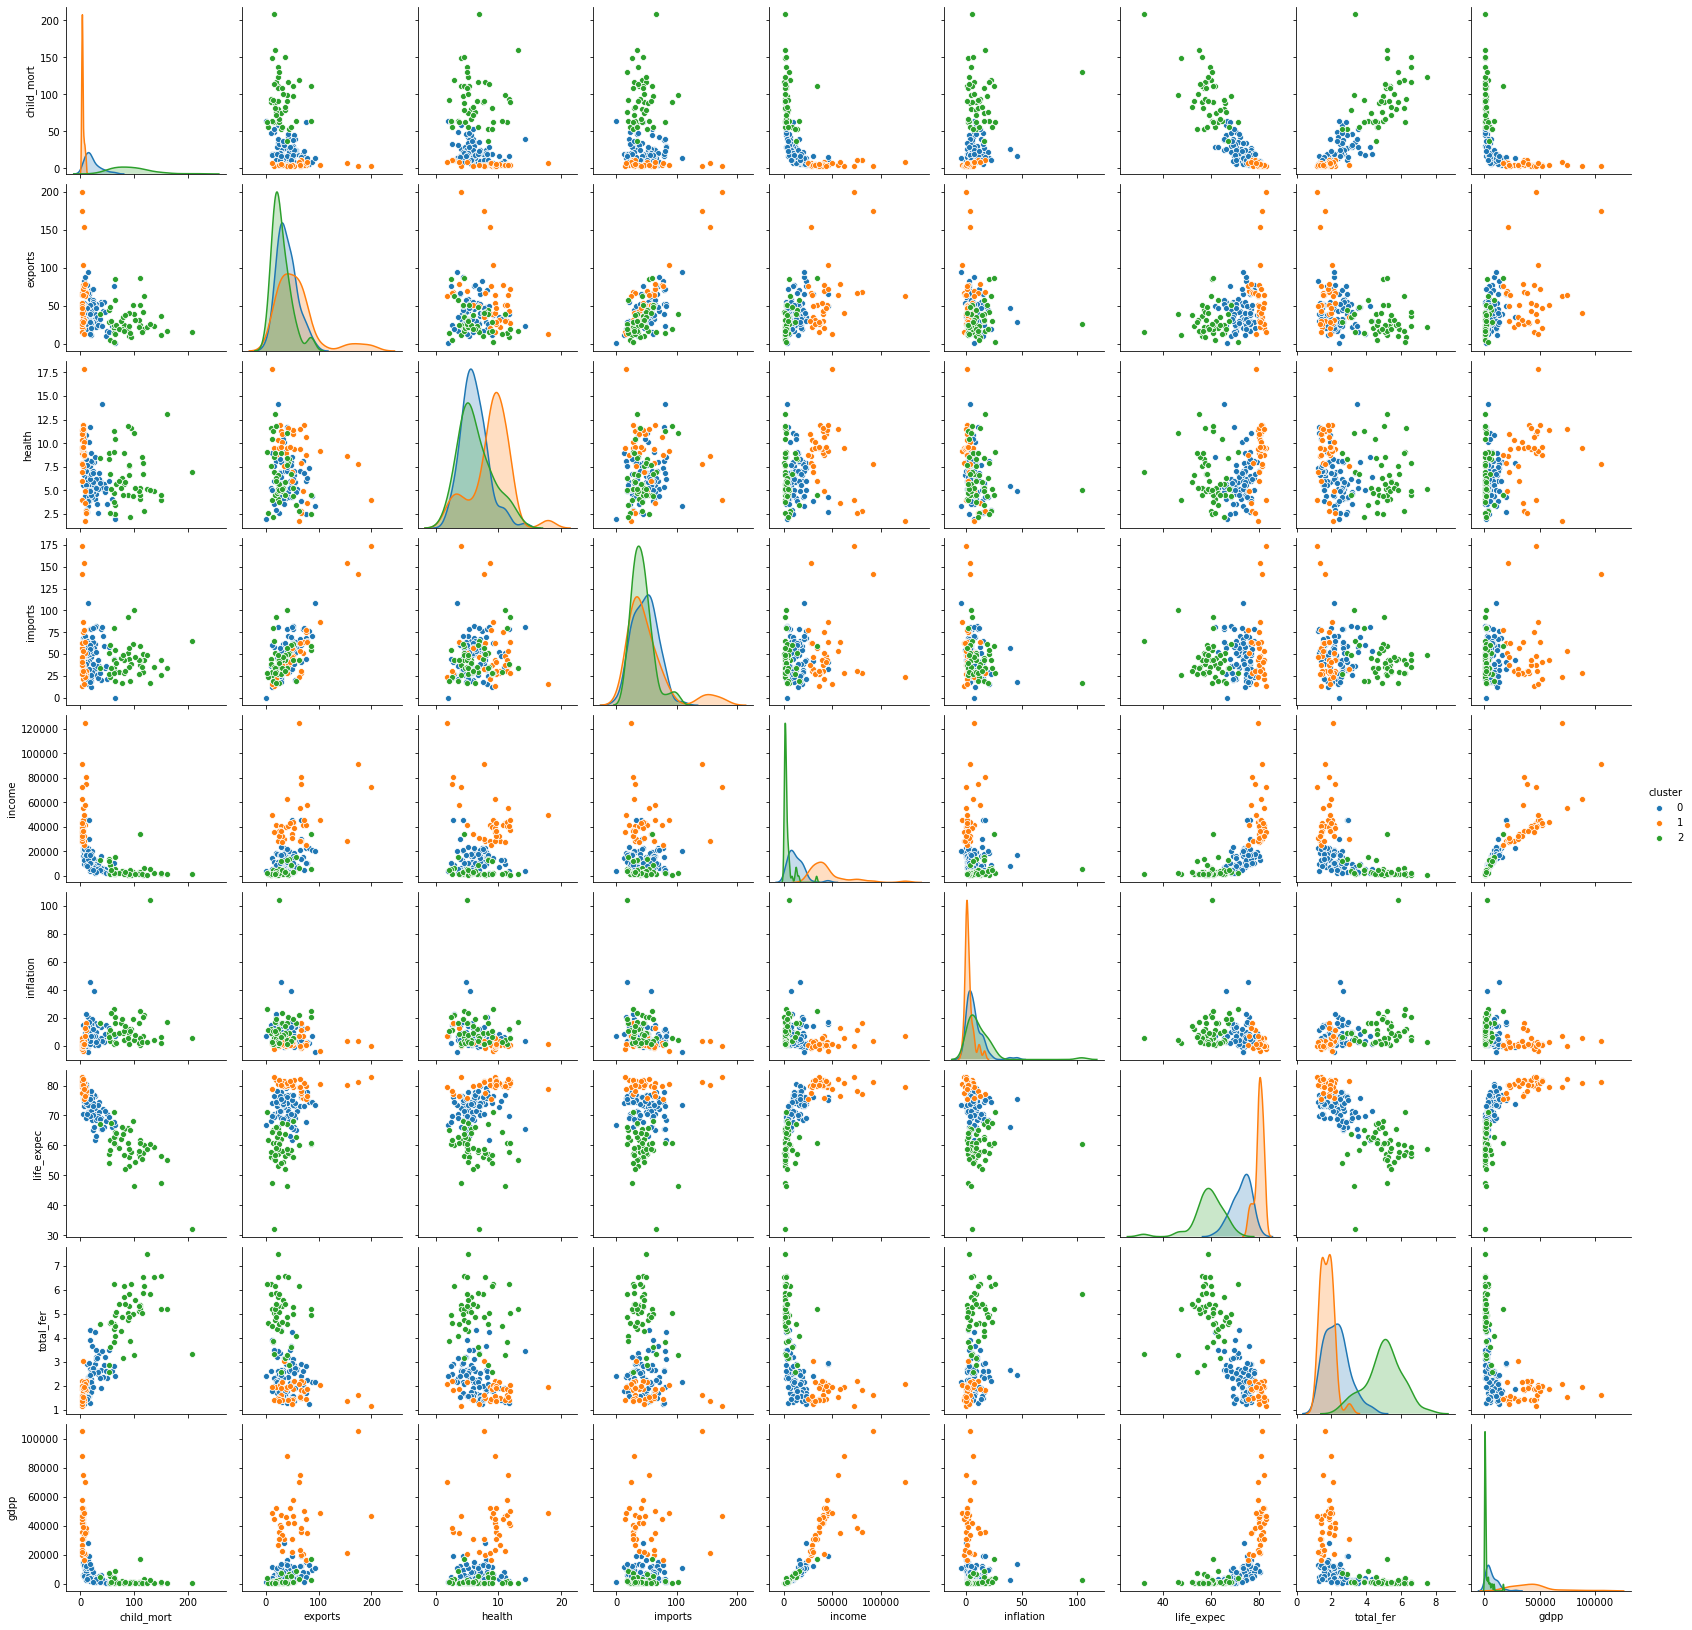

In [62]:
sns.pairplot(scikit_copy.drop(['country'], axis='columns'), hue='cluster')

So, from this plots we can see that:
 - cluster 0: 
     in most categories countries fall somewhere in between cluster 1 and cluster 2
 - cluster 1:
     - lowest children mortality
     - highest income
     - highest life expectancy
     - lowest total fertility
     - highest GDPP
 - cluster 2:
     - highest children mortality
     - lowest income
     - lowest life_expectancy
     - highest total fertility
     - lowest GDPP
     
     
This analysis leads me to believe that we can name these clusters as:
    - cluster 2 - least developed countries
    - cluster 0 - moderately developed countries
    - cluster 1 - highly developed countries

Let's see the countries on this list

In [64]:
print('Least developed countries:')
scikit_copy[scikit_copy['cluster'] == 2]

Least developed countries:


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster,country
0,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,2,Afghanistan
3,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530,2,Angola
17,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,2,Benin
21,52.5,43.60,8.30,51.3,13300,8.920,57.1,2.88,6350,2,Botswana
25,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,2,Burkina Faso
26,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,2,Burundi
28,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,2,Cameroon
31,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,2,Central African Republic
32,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897,2,Chad
36,88.2,16.50,4.51,51.7,1410,3.870,65.9,4.75,769,2,Comoros


In [65]:
print('Moderately developed countries:')
scikit_copy[scikit_copy['cluster'] == 0]

Moderately developed countries:


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster,country
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0,Albania
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0,Algeria
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0,Antigua and Barbuda
5,14.5,18.9,8.10,16.0,18700,20.90,75.8,2.37,10300,0,Argentina
6,18.1,20.8,4.40,45.3,6700,7.77,73.3,1.69,3220,0,Armenia
...,...,...,...,...,...,...,...,...,...,...,...
160,10.6,26.3,8.35,25.4,17100,4.91,76.4,2.08,11900,0,Uruguay
161,36.3,31.7,5.81,28.5,4240,16.50,68.8,2.34,1380,0,Uzbekistan
162,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,0,Vanuatu
163,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,0,Venezuela


In [66]:
print('Highly developed countries:')
scikit_copy[scikit_copy['cluster'] == 1]

Highly developed countries:


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster,country
7,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,1,Australia
8,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1,Austria
11,8.6,69.5,4.97,50.9,41100,7.440,76.0,2.16,20700,1,Bahrain
15,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,1,Belgium
23,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,1,Brunei
29,5.6,29.1,11.30,31.0,40700,2.870,81.3,1.63,47400,1,Canada
42,3.6,50.2,5.97,57.5,33900,2.010,79.9,1.42,30800,1,Cyprus
43,3.4,66.0,7.88,62.9,28300,-1.430,77.5,1.51,19800,1,Czech Republic
44,4.1,50.5,11.40,43.6,44000,3.220,79.5,1.87,58000,1,Denmark
53,3.0,38.7,8.95,37.4,39800,0.351,80.0,1.87,46200,1,Finland


# K-Means Algorithm - My Own Implementation

The algorithm runs as follows:
    1. as a starting point, initialize each centroid to a random sample's coordinates
    2. repeat until max_iter is reached:
        2a. assign each sample to the closest centroid
        2b. calculate new centroids' positions based on the newly assigned points
            (centroid position is calculated as a mean of coordinates of all the points assigned to it)
            
The algorithm is fairly simple, but there is a risk of it not finding the best fit and instead falling into what's called a local minimum of the cost function (in this case inertia). We can prevent it by running the algorithm multiple times, each time with different random samples as initial centroids and then choose the centroids with the lowest cost function.

For simplicity, we will ommit error checking and focus on the algorithm implementation

In [48]:
class CustomKMeans(BaseEstimator):
    '''
    Class implementing the K-Means Clustering algorithm. 
    Implements the scikit's BaseEstimator, which enables us to use it in conjunction
    with other scikit's tools such as Pipeline
    '''
    def __init__(self, n_clusters=3, n_init=10, max_iter=200):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        
        
    def fit(self, X):
        '''
        Performs the K-Means Clustering algorithm.
        Args:
            X - data to be clustered
            n_clusters - number of clusters
            n_init - number of interations to initialize and perform the k means algorithm
        '''
        self.cost_history = []
        self.centroids_history = []
    
        for act_run in range(self.n_init):
            self.centroids = self.get_initial_centroids(X, self.n_clusters)
        
            for i in range(self.max_iter):
                # Assign each data point to the closest centroid.
                # sample_assignments[i] corresponds to i-th row of X, the index of the centroid assigned to example i
                sample_assignments = self.find_closest_centroids(X, self.centroids)
       
                old_centroids = self.centroids.copy()
                # Compute the new centroids based on the newly assigned samples
                self.update_centroids(X, sample_assignments, self.centroids)
            
                # if the centroids stayed the same, they won't change anymore, so we break the loop
                if np.all(old_centroids == self.centroids):
                    break
    
            self.cost_history.append(self.cost_function(X, sample_assignments, self.centroids))
            self.centroids_history.append(self.centroids)
            
        self.centroids = self.find_best_params()
        
        
    def predict(self, X):
        '''Assigns the samples from the dataset to clusters'''
        return self.find_closest_centroids(X, self.centroids)
    
    
    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)

            
    def get_initial_centroids(self, X, n_clusters):
        '''Chooses n_clusters random samples from the data as the initial centroids'''
        random_indexes = np.random.choice(X.shape[0], n_clusters)
        return X[random_indexes, :]


    def find_closest_centroids(self, X, centroids):
        '''Assign each sample to its closest centroid'''
        sample_assignments = []
        for sample in X:
            distances = np.linalg.norm(sample - centroids, axis=1)
            min_index = np.argmin(distances)
            sample_assignments.append(min_index)
        return np.array(sample_assignments)


    def update_centroids(self, X, sample_assignments, centroids):
        '''Computes new coordinates for each centroid based on the assigned samples'''
        for k in range(centroids.shape[0]):
            samples_assigned_to_centroid = (sample_assignments == k)
            centroids[k,:] = np.mean(X[samples_assigned_to_centroid], axis=0)
        
        
    def cost_function(self, X, sample_assignments, centroids):
        '''Calculates the inertia of the model with given centroids'''
        cost = 0
        for i in range(X.shape[0]):
            sample_centroid = sample_assignments[i]
            cost += np.linalg.norm(X[i,:] - centroids[sample_centroid,:])
        return cost / X.shape[0]


    def find_best_params(self):
        best_index = np.argmin(self.cost_history)
        return self.centroids_history[best_index]

In [50]:
model = CustomKMeans(n_clusters=3)

custom_copy = data.copy()
X_custom_scaled = scaler.transform(custom_copy)

custom_clusters = model.fit_predict(X_custom_scaled)

In [51]:
custom_copy['country'] = country_names
custom_copy['cluster'] = custom_clusters
custom_copy

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,country,cluster
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,Afghanistan,1
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,Albania,0
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,Algeria,0
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,Angola,1
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,Antigua and Barbuda,0
...,...,...,...,...,...,...,...,...,...,...,...
162,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,Vanuatu,0
163,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,Venezuela,0
164,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,Vietnam,0
165,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,Yemen,1


In [52]:
print(custom_copy['cluster'].value_counts())
print()
print('Centroid coordinates:')
print(model.centroids)

0    84
1    47
2    36
Name: cluster, dtype: int64

Centroid coordinates:
[[-0.40645337 -0.03165259 -0.2244709   0.02416161 -0.25177041 -0.01716742
   0.25473362 -0.42434279 -0.35448141]
 [ 1.36021776 -0.43753313 -0.15598401 -0.18920377 -0.68689408  0.40211078
  -1.28217981  1.36494385 -0.60424243]
 [-0.82744866  0.64507985  0.72741122  0.19063895  1.48424268 -0.48492064
   1.07957853 -0.79187687  1.61599536]]


So, as we can see the samples were divided into clusters the same way as scikit's implementation.

We can also look at the column of the least developed countries for comparison

In [67]:
print('Highly developed countries:')
custom_copy[custom_copy['cluster'] == 1]

Highly developed countries:


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,country,cluster
0,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,Afghanistan,1
3,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530,Angola,1
17,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,Benin,1
21,52.5,43.60,8.30,51.3,13300,8.920,57.1,2.88,6350,Botswana,1
25,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,Burkina Faso,1
26,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,Burundi,1
28,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,Cameroon,1
31,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,Central African Republic,1
32,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897,Chad,1
36,88.2,16.50,4.51,51.7,1410,3.870,65.9,4.75,769,Comoros,1


Ok, so we can see that this cluster is the same as cluster of least developed countries from the scikit implementation.